# Data Analyse

I dette notebook undersøger vi vores data nærmere. Det gør vi både i form af at plotte dataen, samt at se nærmere på fordelingen af labels, samlet set i hele vores dataset, og på tværs af epochs og batches.


### Import dataloader

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from get_data import get_dataset
from data._data_static import TEGNINGER

In [2]:
BATCH_SIZE = 64
train_loader, val_loader = get_dataset(
    names=TEGNINGER,
    n_samples=30000,
    batch_size=BATCH_SIZE,
    verbose=False,
)

# Hent det fulde træning og valideringssæt
X_train = train_loader.dataset.tensors[0]
y_train = train_loader.dataset.tensors[1]

X_val = val_loader.dataset.tensors[0]
y_val = val_loader.dataset.tensors[1]

N_klasser = len(TEGNINGER)
N_data = len(train_loader.dataset)
N_dim = train_loader.dataset[0][0].numpy().shape

print(
f"""Vi har {N_data} doodles (datapunkter), der fordeler sig over {N_klasser} klasser.
Hver doodle har dimensionerne {N_dim}.

Det betyder at vores træningsdata (X-matricen) har formen: ({N_data} x {N_dim[0]} x {N_dim[1]})
og vores labels (y-vektoren) har formen: {N_data}
"""
)

Vi har 3405374 doodles (datapunkter), der fordeler sig over 30 klasser.
Hver doodle har dimensionerne (28, 28).

Det betyder at vores træningsdata (X-matricen) har formen: (3405374 x 28 x 28)
og vores labels (y-vektoren) har formen: 3405374



## 1. Analyse af dataen
### 1.1 Lad os plotte nogle data exempler

I koden nedenunder plotter vi de datapunkter der er i vores første 2 data batches i vores første epoche

In [3]:
def plot_figure(billeder: torch.Tensor, labels: torch.Tensor, ns: torch.Tensor) -> None:
    """
    Plot en grid af billeder og deres labels.
    Args:
        billeder (torch.Tensor): En tensor af billeder.
        labels (torch.Tensor): En tensor af labels.
        ns (int): Hvor mange rækker og kolonner vores grid har.

    Returns:
        None
    """
    # Definer figuren
    fig, ax = plt.subplots(figsize=(14, 14), nrows=ns, ncols=ns, sharex=True, sharey=True, layout='tight')

    for i in range(ns):
        for j in range(ns):
            # Plot det (i*ns +j)th billede
            ax[i, j].imshow(billeder[i*ns+j].reshape((28, 28)).numpy(), cmap="Greys")
            ax[i, j].set_title(TEGNINGER[int(labels[i*ns+j].item())])
            ax[i, j].axis('off')
    # Sæt title for hele figuren
    plt.suptitle(
        f"Billeder og deres labels i et batch med batch_size ={BATCH_SIZE}",
        fontsize=20, style='oblique',
    )
    plt.show()

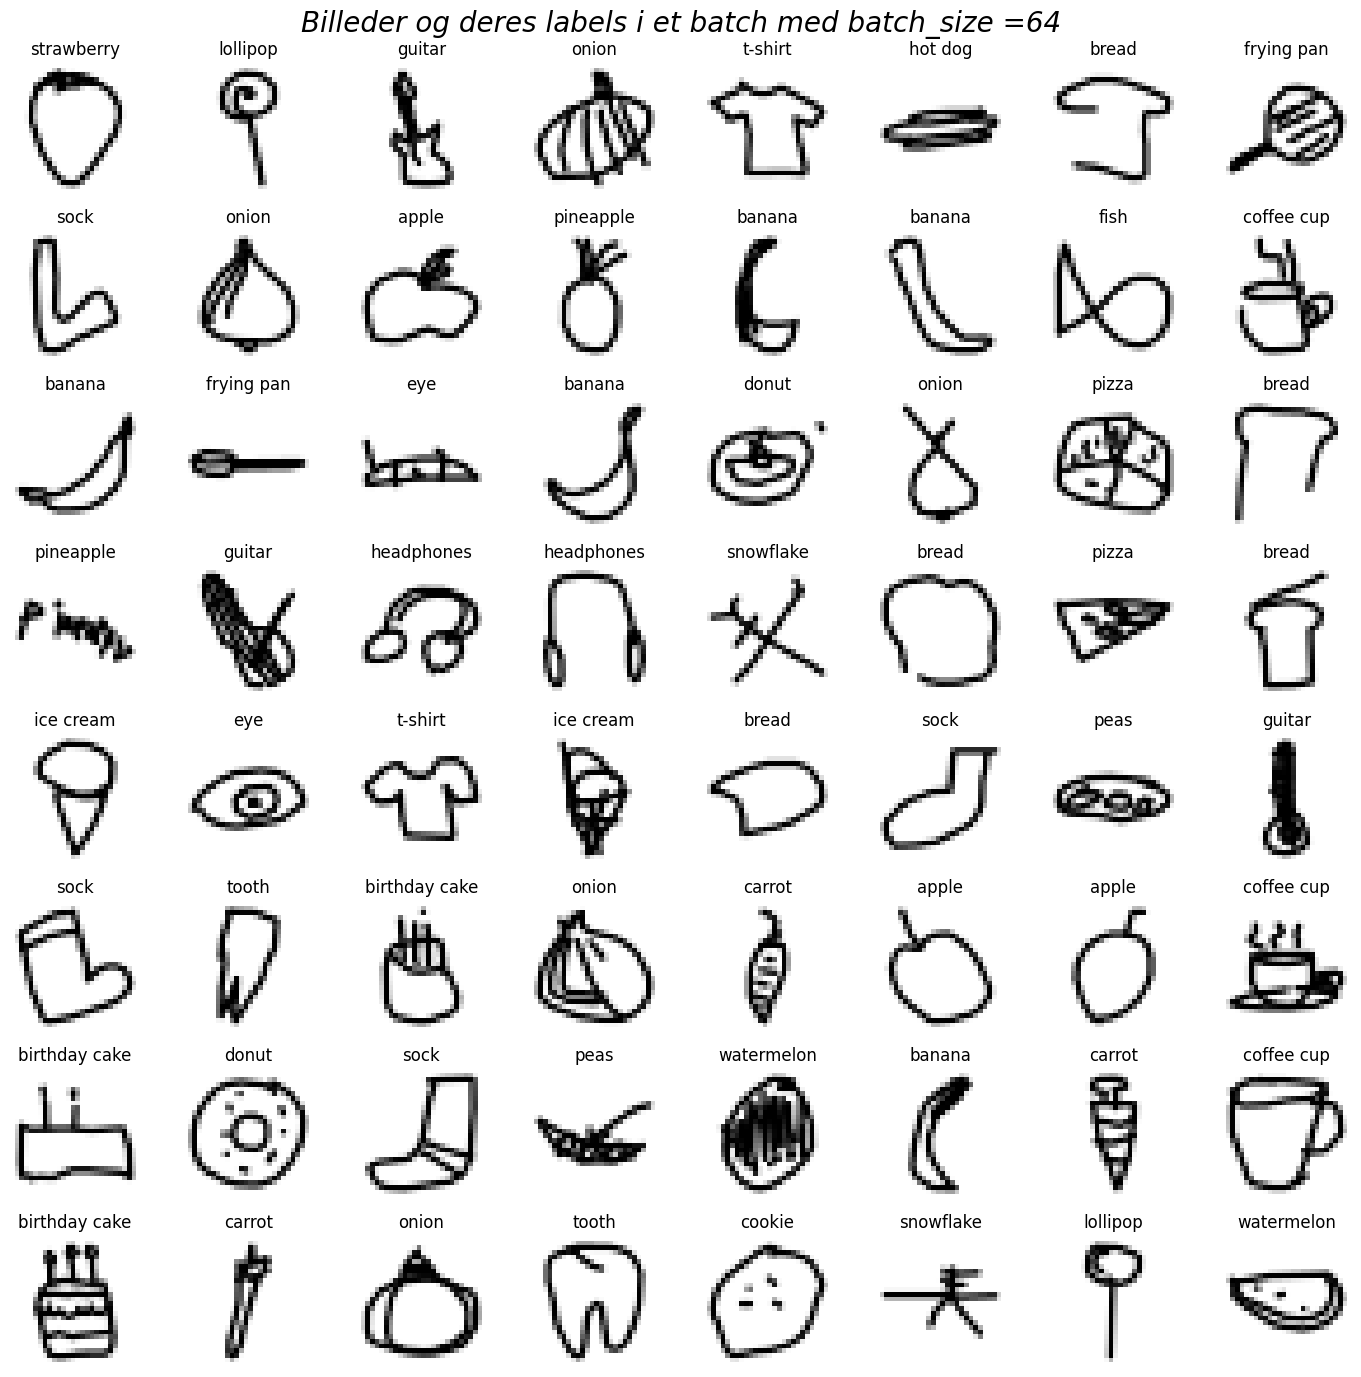

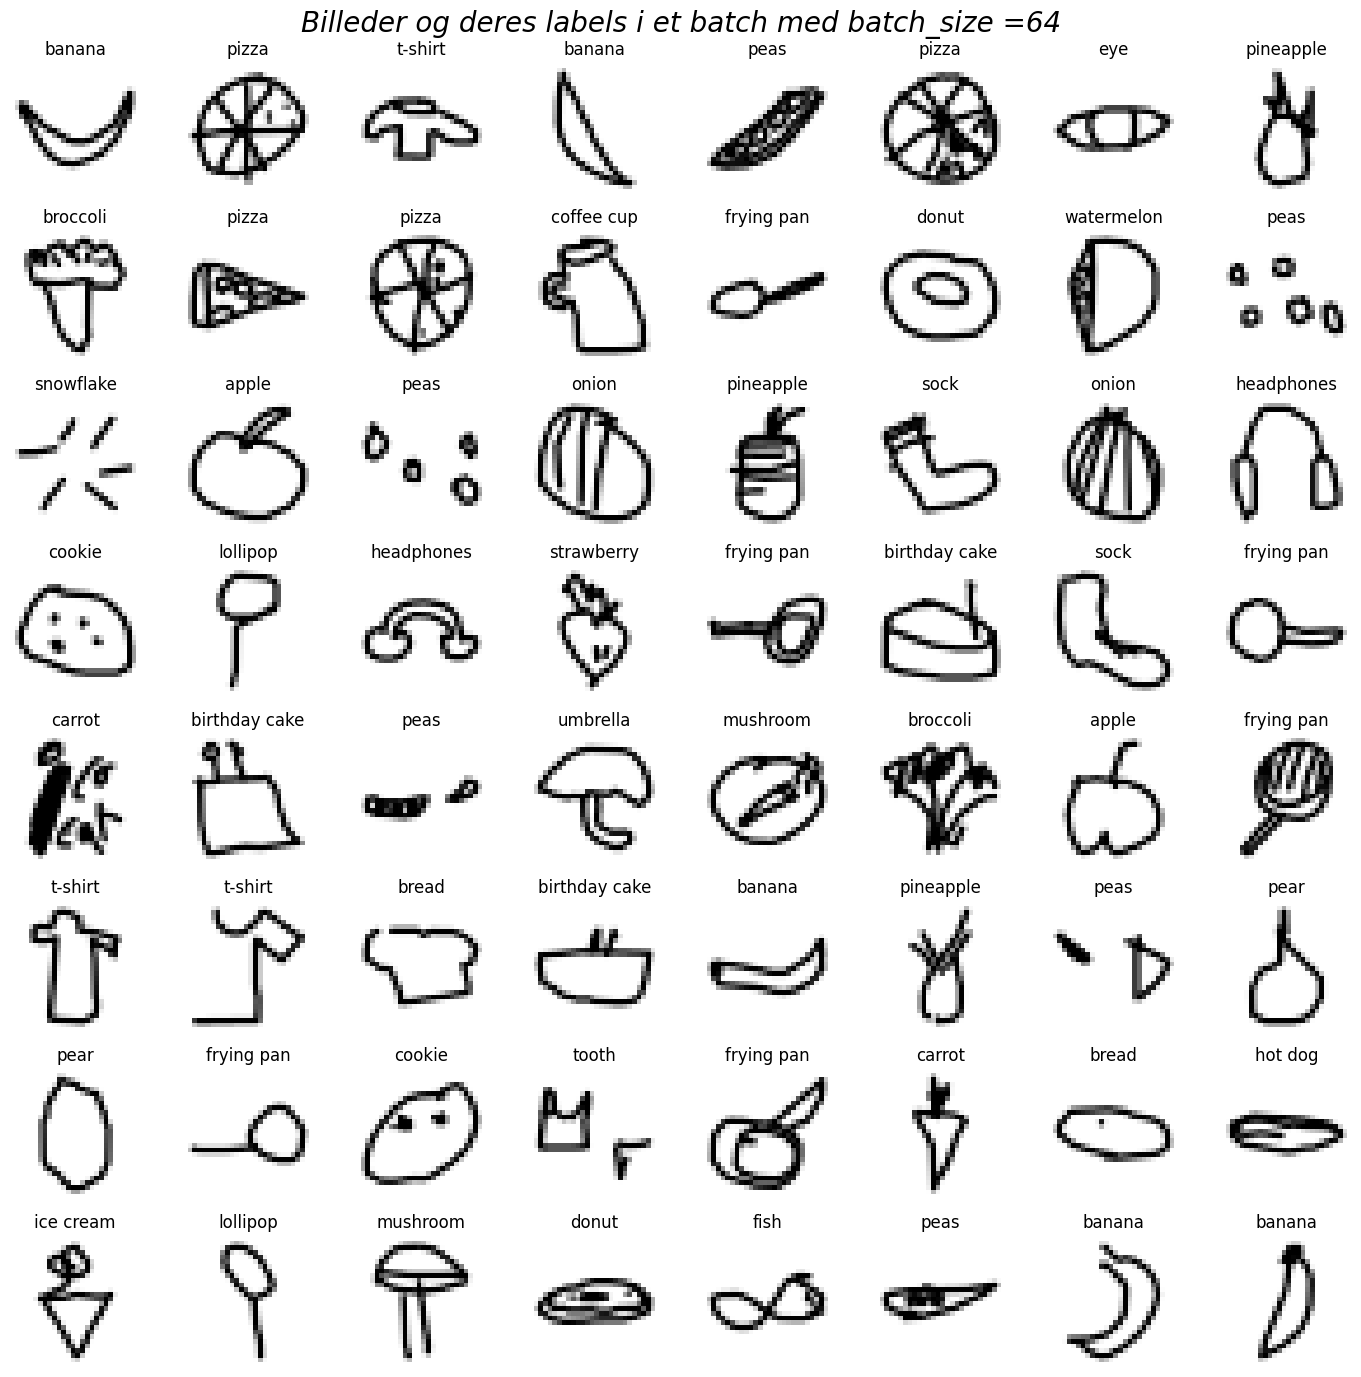

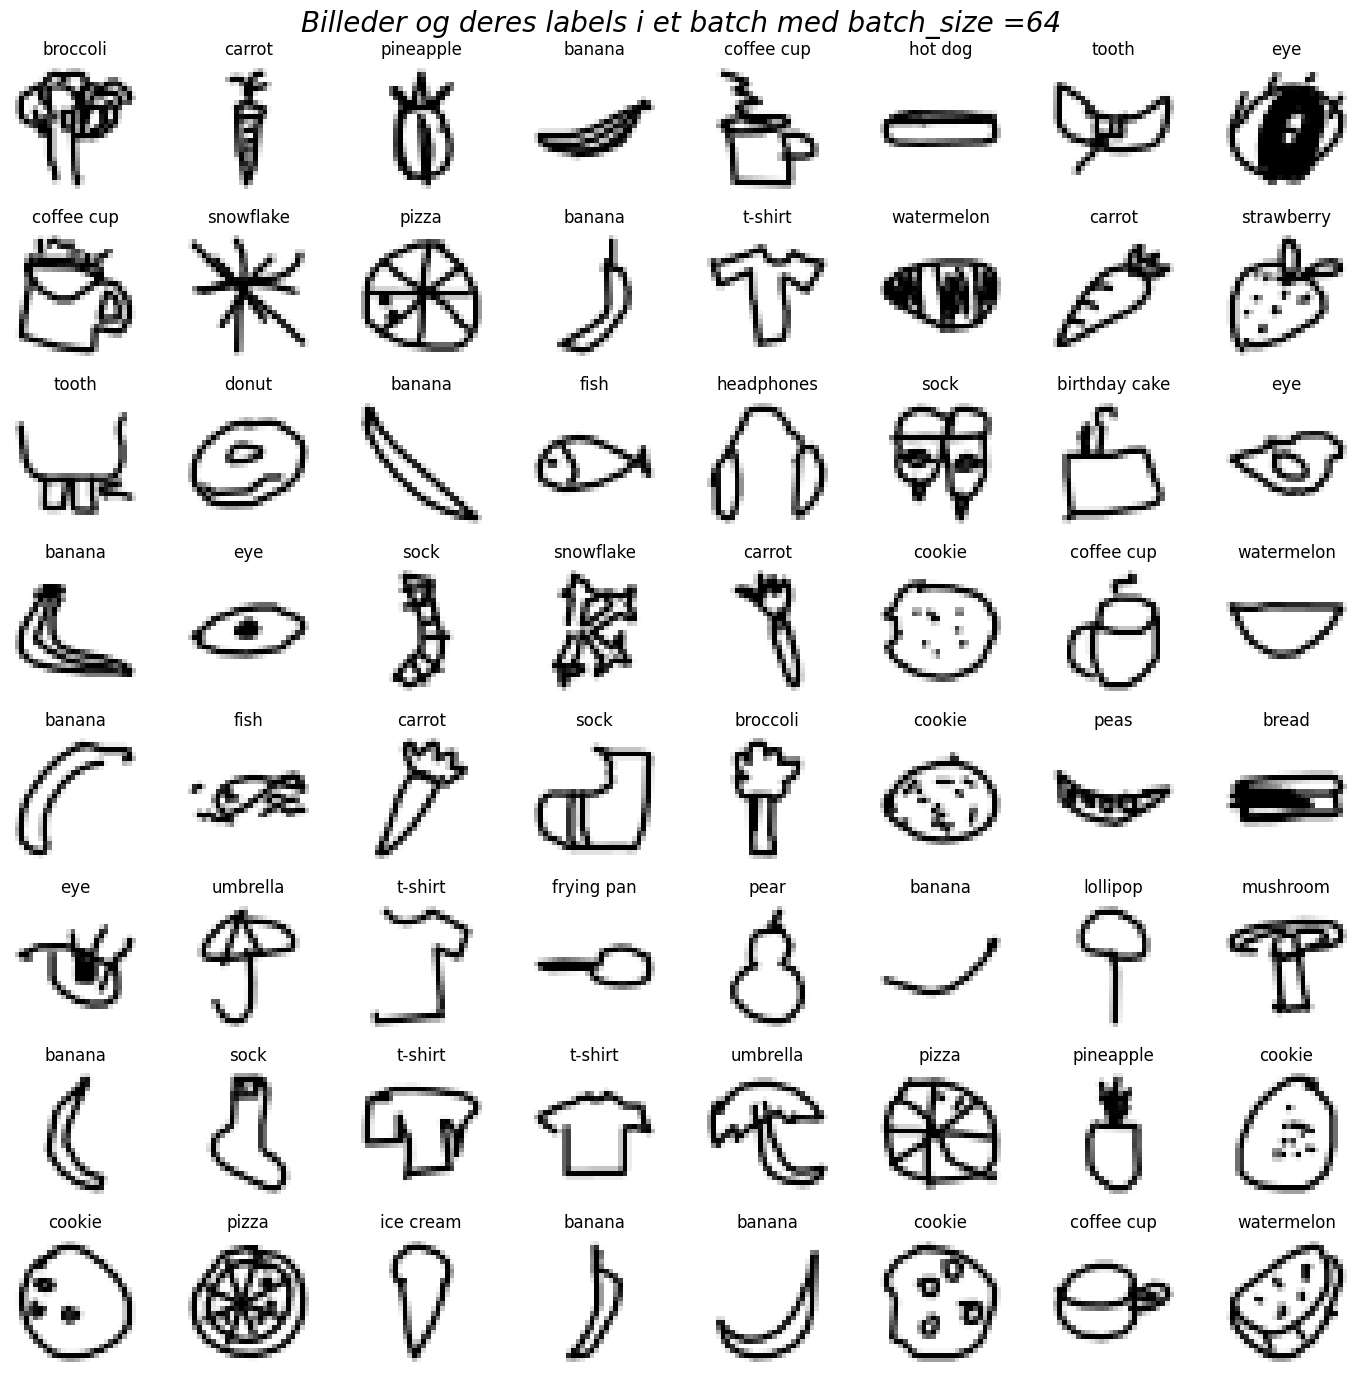

In [4]:
# Loop over batchene 0, 1, 2
for b, (image, label) in enumerate(train_loader):
    # Plot gridet af billeder og labels for batch b
    plot_figure(image, label, 8)
    
    # Stop loopet hvis b >= 2
    if b >= 2:
        break

### 1.2 Hvordan ser den gennemsnitlige tegning ud?

Når vi arbejder med billeder kan det være en meget god ide at kigge på det gennemsnitlige billede for en bestemt klasse.

Denne finder vi ved at average over alle vores data eksempler, der har en bestemt label og så plotte den tilsvarende gennemsnitlige doodle.

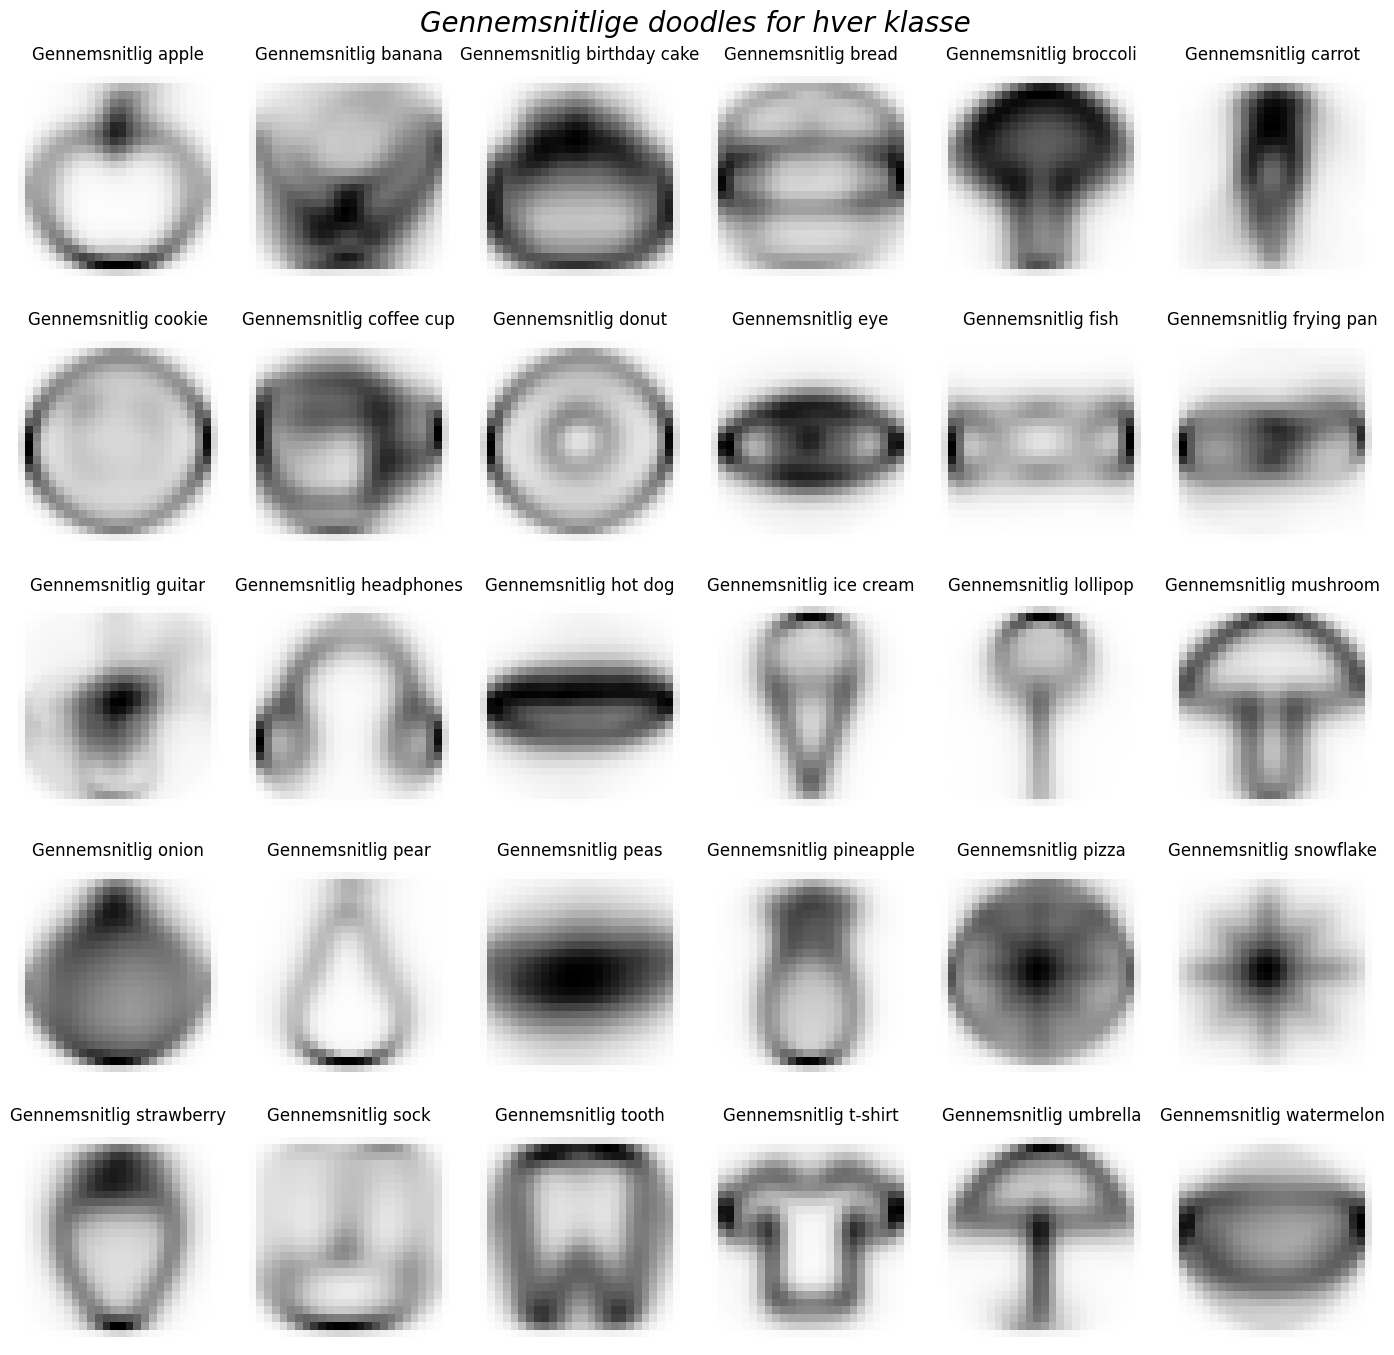

In [5]:
def get_average_doodle(doodles: torch.Tensor) -> torch.Tensor:
    """
    Beregn gennemsnittet af nogle doodles.
    Args:
        doodles (torch.Tensor): En tensor af doodles.

    Returns:
        torch.Tensor: Den gennemsnitlige doodle.
    """
    return torch.mean(doodles, dim=0)

fig, ax = plt.subplots(figsize=(14, 14), nrows=5, ncols=6, sharex=True, sharey=True, layout='tight')
for i, tegning in enumerate(TEGNINGER):
    # Hent gennemsnittet af doodles for klassen 'tegning'
    avg_doodle = get_average_doodle(X_train[y_train == TEGNINGER.index(tegning)])

    # Plot gennemsnittet af doodles for klassen 'tegning'
    ax[i//6, i%6].imshow(avg_doodle.reshape((28, 28)).numpy(), cmap="Greys")
    ax[i//6, i%6].set_title(f"Gennemsnitlig {tegning}")
    ax[i//6, i%6].axis('off')
plt.suptitle(
    "Gennemsnitlige doodles for hver klasse",
    fontsize=20, style='oblique',
)
plt.show()


Hvad kan vi se hvis vi undersøger de gennemsnitlige billeder nærmere? Hvilke billeder ville du regne med kommer til at være lette for klassifikatoren at klassificere? Hvilke billeder tænker du den typisk vil forveksle?

# 2. Dataloaderen
## 2.1 Lad os checke om distributionen af labels er fordelt ens imellem trainings- og test- sættet for hver klasse (aka. at vi har splittet vores dataset med stratificering)

I vores `get_dataset` function loader vi dataen og splitter derefter dataen imellem vores træning og validerings sæt (med 80% af dataen til træning og 20% til validering) med stratificering af klasserne. Med andre ord sørger vi for at forholdet 80%:20% gælder ikke bare for alt data, men for hver label.

Lad os checke at dette kan ses i vores data:

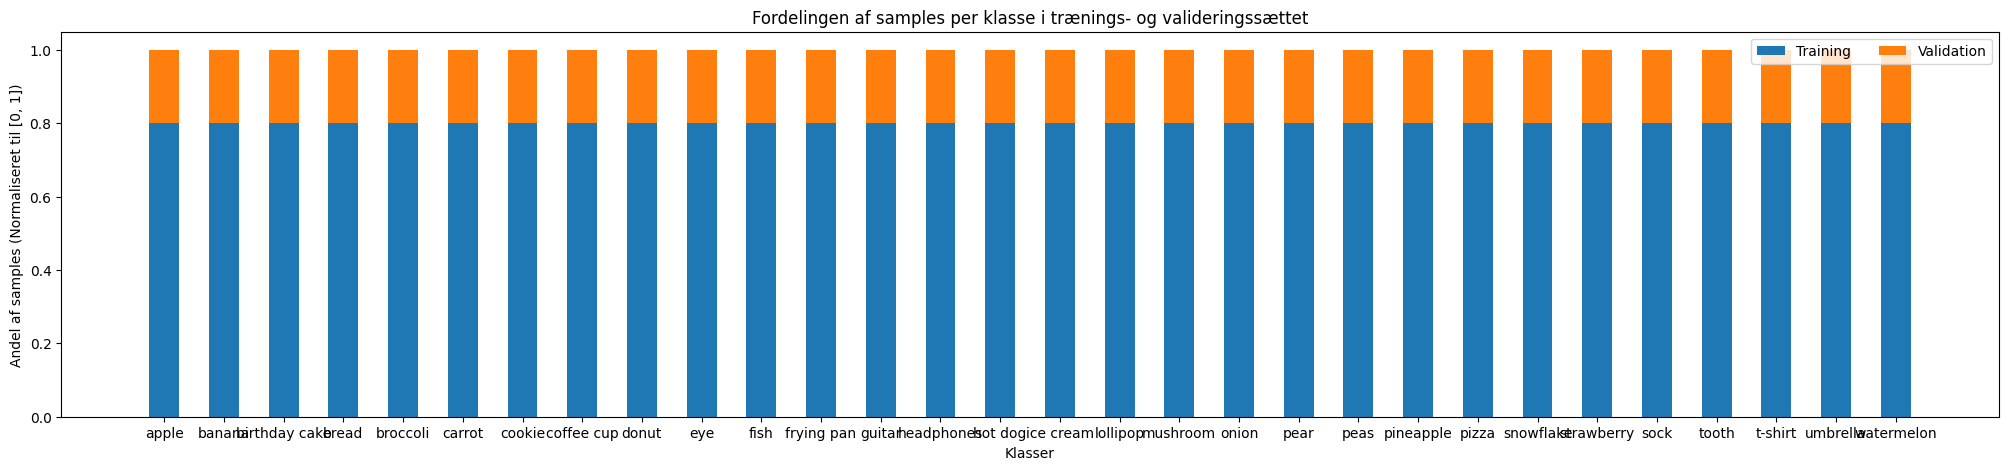

In [8]:
# Tæl antallet af samples per klasse i trænings- og valideringssættet
dist = {
    label: [
        sum(y == i).item() for i, tegninger in enumerate(TEGNINGER)
    ] for label, y in zip(["Training", "Validation"], [y_train, y_val])
}

# Normaliser antallet så de to fordelinger summer til 1 for hver klasse
norm_dist = {
    "Training": [
        dist["Training"][i] / (dist["Training"][i] + dist["Validation"][i])
        for i in range(len(TEGNINGER))
    ],
    "Validation": [
        dist["Validation"][i] / (dist["Training"][i] + dist["Validation"][i])
        for i in range(len(TEGNINGER))
    ],
}

# Plot antallet af samples per klasse i trænings- og valideringssættet
fig, ax = plt.subplots(figsize=(25, 5))
bottom = np.zeros(len(list(norm_dist.values())[0]))

x = TEGNINGER
width = 0.5

for label, count in norm_dist.items():
    ax.bar(x, count, width, label=label, bottom=bottom)
    bottom += count
ax.set_title("Fordelingen af samples per klasse i trænings- og valideringssættet")
ax.set_xlabel("Klasser")
ax.set_ylabel("Andel af samples (Normaliseret til [0, 1])")
ax.legend(ncol=2, loc="upper right")
plt.show()

Når du kigger på figuren ovenover, ville du mene at vi kan vide os sikker at vores training-validerings split er stratificeret for hver klasse?

## 2.2 Lad os se nærmere på fordelingen af klasserne på tværs af de forskellige batches indenfor et epoch

I vores `get_dataset` function sampler vi `n_samples` (i denne notebook sat til 30000) tilfældige datapunkter fra hhv. vores træning og validerings-sæt som vi træner og validerer på i hvert epoch. Lad os kigge nærmere på hvordan vores klasser fordeller sig på tværs af forskellige batches i en epoche. Arbejder vi i samplingen også med stratificering?

In [10]:
def get_dist(loader, by: str = "batch"):
    """
    Beregn fordelingen af samples per klasse per batch eller per batch per klasse.
    Args:
        loader (torch.utils.data.DataLoader): Data loaderen.
        by (str): Fordelingsformen. Enten "batch" eller "tegning".
    
    Returns:
        dist (dict): Distributionsobjektet.
    """
    if by == "batch":
        # Initializer fordelingen
        dist = {f"Batch {e}": np.zeros(len(TEGNINGER)) for e in range(len(loader))}
        # Loop over batchene
        for e, (_, labels) in enumerate(loader):
            for label in labels:
                # Opdater fordelingen
                dist[f"Batch {e}"][int(label)] += 1
            
    elif by == "tegning":
        # Initializer fordelingen
        dist = {TEGNINGER[i]: np.zeros(len(loader)) for i in range(len(TEGNINGER))}
        # Loop over the batchene
        for e, (_, labels) in enumerate(loader):
            for label in labels:
                # Opdater fordelingen
                dist[TEGNINGER[int(label)]][e] += 1
                
    return dist

def plot_dist(loader = train_loader, by: str = "batch", width: int = 0.5):
    """
    Plot fordelingen af samples per klasse per batch eller per batch per klasse.
    Args:
        loader (torch.utils.data.DataLoader): Data loaderen.
        by (str): Fordelingsformen. Enten "batch" eller "tegning".
        width (int): Bredden af barene i plottet

    Returns:
        None
    """
    # Beregn fordelingen
    dist = get_dist(loader, by)

    # Initializer figuren
    fig, ax = plt.subplots(figsize=(15, 5))
    bottom = np.zeros(len(list(dist.values())[0]))

    # Sæt x-aksen
    if by == "batch":
        x = TEGNINGER
    else:
        x = [f"Batch {e}" for e in range(len(loader))]

    # Plot fordelingen
    for label, count in dist.items():
        ax.bar(x, count, width, label=label, bottom=bottom)
        bottom += count
        if by == "batch":
            plt.xticks(rotation=45)
    ax.set_title(
        "Antallet af samples per klasse per batch" 
        if by == "batch" else "Antallet af samples per batch per klasse"
    )
    ax.legend(ncol=8, loc="upper right")
    plt.show()

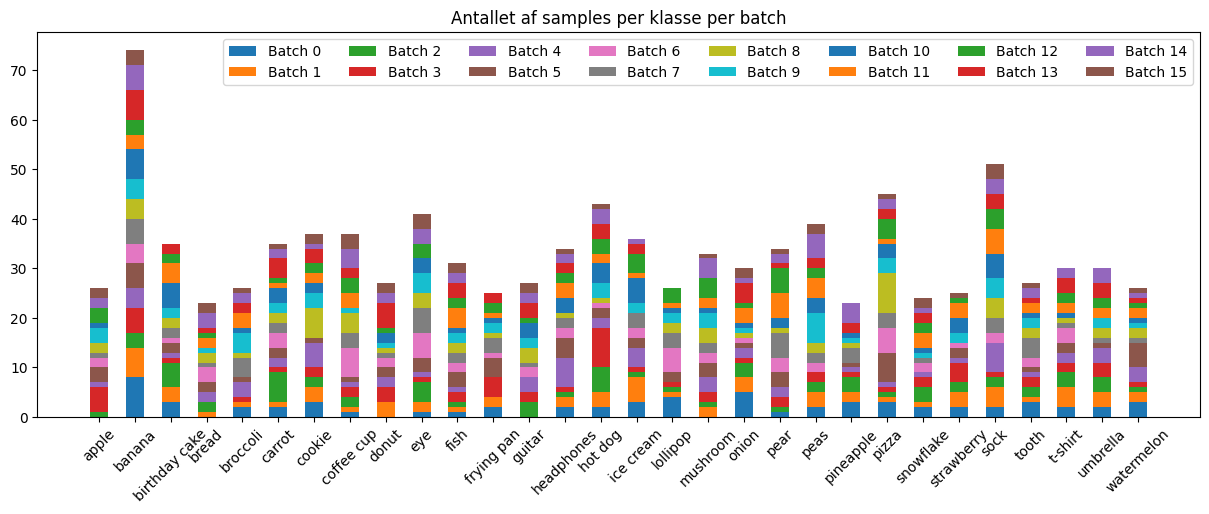

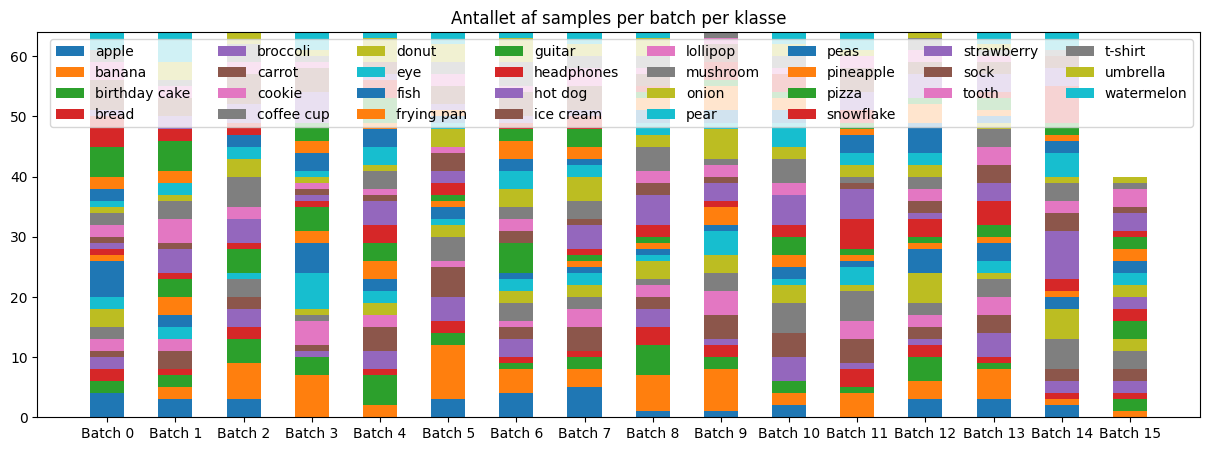

In [11]:
plot_dist(train_loader, "batch")
plot_dist(train_loader, "tegning")

## 2.3 Lad os til sidst kigge på om fordelingen af labels i forskellige batches over diverse epocher ændrer sig

Vi ønsker at distributionen af hver klasse i en bestemt batch i en bestemt epoch er forskellig fra alle andre batches og epocher. Så lad os undersøge om dette holder for vores data.

In [ ]:
print("Er fordelingerne de samme på tværs af epoker?")

def are_dicts_equal(dict1, dict2):
    """
    Check om to dictionaries er ens.
    Args:
        dict1 (dict): Den første dictionary.
        dict2 (dict): Den anden dictionary.
    
    Returns:
        bool: True hvis de er ens, ellers False.
    """
    if set(dict1.keys()) != set(dict2.keys()):
        # Hvis nøglerne ikke er de samme, er dictionary'rne ikke ens
        return False
    
    for key in dict1.keys():
        # Loop over nøglerne og check om værdierne er ens
        if not np.all(dict1[key] == dict2[key]):
            # Hvis værdierne ikke er de samme, er dictionary'rne ikke ens
            return False
    return True

# Hent fordelingen for 100 epochs (sample dataen 100 gange)
dists = []
for e in range(100):
    train_dist = get_dist(train_loader, by="batch")
    dists.append(train_dist)

# check om der er nogen ens fordelinger
same_dist = False
for i in range(len(dists)-1):
    for j in range(i+1, len(dists)):
        if are_dicts_equal(dists[i],dists[j]):
            print("Ens distributioner fundet for epoch", i, "og", j)
            same_dist = True
            break

if not same_dist:    
    print("Alle distributioner are forskellige")

Are the distributions the same across epochs?
All distributions are different


Hvorfor er vi interesseret i at distributionen af vores klasser er forskellig fra epoch til epoch?

# 3. Plads til andre data analyser du måske kunne være interesseret i at lave
Herunder kan du analysere dataen ydeligere, hvis du ønsker det. God fornøjelse :)